In [41]:
from datetime import datetime
import math
import os
import random
import numpy as np
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


# Mount Drive and helper functions

In [3]:
import os
from google.colab import drive

In [4]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# save file do google drive
def save_to_drive(file_name, spec_command='', dest_dir='Lab3'):
  print(f"!cp {spec_command} ./{file_name} /content/drive/MyDrive/{dest_dir}")
  !cp {spec_command} ./{file_name} /content/drive/MyDrive/{dest_dir}

In [6]:
# load file from google drive
def load_from_drive(file_name, spec_command='', file_dir='Lab3'):
  print(f"!cp {spec_command} /content/drive/MyDrive/{file_dir} /content")
  !cp {spec_command} /content/drive/MyDrive/{file_dir} /content

## Calculate file count

In [8]:
import os

def calculate_files(path):
  # Define the path to the folder
  folder_path = path
  # Initialize the file count
  file_count = 0

  # Walk through the folder and its subfolders
  for root, dirs, files in os.walk(folder_path):
      # Add the number of files in the current folder to the file count
      file_count += len(files)

  # Print the total number of files
  print(f'The folder "{path}" its subfolders contain {file_count} files.')
  return file_count

# Load from drive

In [ ]:
import shutil
shutil.rmtree("./Lab3")

In [9]:
load_from_drive('Data', spec_command='-r', file_dir="Lab3_2")
calculate_files("./Lab3_2/train2017/images")

The folder "./Lab3_2/train2017/images" its subfolders contain 1774 files.


1774

# Dataset

In [10]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
import random

class SegmentationDataset(Dataset):
    def __init__(self, data_dir, is_train=False):
        self.data_dir = data_dir
        self.is_train = is_train
        # self.transforms = transforms
        # self.normalization = normalization
        self.image_names = os.listdir(os.path.join(self.data_dir, "images"))
        
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, "images", self.image_names[idx])
        mask_path = os.path.join(self.data_dir, "masks", self.image_names[idx] + ".png")
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # if self.transforms is not None:
        #     image, mask = self.transforms(image, mask)
        #     # image = self.transforms(image)
        #     # mask = self.transforms(mask)
        #     image = self.normalization(image)

        image_name = os.path.splitext(self.image_names[idx])[0]    
        image, mask = self.transform(image, mask)
        return image, mask, image_name

    def transform(self, img, mask):
        if self.is_train:
            img = transforms.functional.resize(img, (280, 280))
            mask = transforms.functional.resize(mask, (280, 280))

            img = transforms.functional.pad(img, 2)
            mask = transforms.functional.pad(mask, 2)

            rotate_params = transforms.RandomRotation.get_params([-30.0, 30.0])
            img = transforms.functional.rotate(img, rotate_params)
            mask = transforms.functional.rotate(mask, rotate_params)

            crop_params = transforms.RandomCrop.get_params(img, output_size = (256, 256))
            img = transforms.functional.crop(img, *crop_params)
            mask = transforms.functional.crop(mask, *crop_params)

            
            if random.random() > 0.5:
                  img = transforms.functional.hflip(img)
                  mask = transforms.functional.hflip(mask)

        else:
            img = transforms.functional.resize(img, (256, 256))
            mask = transforms.functional.resize(mask, (256, 256))
                
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = transforms.functional.to_tensor(mask)

        return img, mask


## not uniform transforms

In [ ]:
import torchvision.transforms as transforms

# Define the transforms for the training and validation sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

normalize_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define a custom transform to apply the same transforms to both the image and mask
class SegmentationTransform(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        # Apply the same transforms to both the image and mask
        img = self.transforms(img)
        mask = self.transforms(mask)

        return img, mask


## Model

In [11]:
class FCNNet(torch.nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    
    self.conv1_1 = torch.nn.Conv2d(in_channels, 16, (3, 3), padding = 'same')
    self.relu1_1 = torch.nn.ReLU()
    self.conv1_2 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu1_2 = torch.nn.ReLU()
    
    self.pool2 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv2_1 = torch.nn.Conv2d(16, 32, (3, 3), padding = 'same')
    self.relu2_1 = torch.nn.ReLU()
    self.conv2_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.relu2_2 = torch.nn.ReLU()
    
    self.pool3 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv3_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.relu3_1 = torch.nn.ReLU()
    self.conv3_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.relu3_2 = torch.nn.ReLU()
    
    self.pool4 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv4_1 = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
    self.relu4_1 = torch.nn.ReLU()
    self.conv4_2 = torch.nn.Conv2d(128, 128, (3, 3), padding = 'same')
    self.relu4_2 = torch.nn.ReLU()
    self.conv4_3 = torch.nn.Conv2d(128, 64, (3, 3), padding = 'same')
    self.relu4_3 = torch.nn.ReLU()
    self.upscale4 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv5_1 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.relu5_1 = torch.nn.ReLU()
    self.conv5_2 = torch.nn.Conv2d(64, 32, (3, 3), padding = 'same')
    self.relu5_2 = torch.nn.ReLU()
    self.upscale5 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv6_1 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.relu6_1 = torch.nn.ReLU()
    self.conv6_2 = torch.nn.Conv2d(32, 16, (3, 3), padding = 'same')
    self.relu6_2 = torch.nn.ReLU()
    self.upscale6 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv7_1 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu7_1 = torch.nn.ReLU()
    self.conv7_2 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu7_2 = torch.nn.ReLU()
    
    self.conv8 = torch.nn.Conv2d(16, 4, (1, 1))
    self.softmax8 = torch.nn.Softmax()

  def forward(self, x):
    block1 = torch.nn.Sequential(
        self.conv1_1,
        self.relu1_1,
        self.conv1_2,
        self.relu1_2
    )(x)
    block2 = torch.nn.Sequential(
        self.pool2,
        self.conv2_1,
        self.relu2_1,
        self.conv2_2,
        self.relu2_2,
    )(block1)
    block3 = torch.nn.Sequential(
        self.pool3,
        self.conv3_1,
        self.relu3_1,
        self.conv3_2,
        self.relu3_2,
    )(block2)
    block4 = torch.nn.Sequential(
        self.pool4,
        self.conv4_1,
        self.relu4_1,
        self.conv4_2,
        self.relu4_2,
        self.conv4_3,
        self.relu4_3,
        self.upscale4,
    )(block3) + block3
    block5 = torch.nn.Sequential(
        self.conv5_1,
        self.relu5_1,
        self.conv5_2,
        self.relu5_2,
        self.upscale5,
    )(block4) + block2
    block6 = torch.nn.Sequential(
        self.conv6_1,
        self.relu6_1,
        self.conv6_2,
        self.relu6_2,
        self.upscale6,
    )(block5) + block1
    block7 = torch.nn.Sequential(
        self.conv7_1,
        self.relu7_1,
        self.conv7_2,
        self.relu7_2,
    )(block6)
    block8 = torch.nn.Sequential(
        self.conv8,
        self.softmax8
    )(block7)
    return block8

In [ ]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_shape, out_classes=4):
        super().__init__()

        # Downsample path
        self.down_conv_1 = nn.Sequential(
            nn.Conv2d(in_shape, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.down_conv_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.down_conv_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.down_conv_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Upsample path
        self.up_conv_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.up_conv_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.up_conv_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.up_conv_4 = nn.Conv2d(64, out_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Downsample path
        x1 = self.down_conv_1(x)
        x2 = self.down_conv_2(x1)
        x3 = self.down_conv_3(x2)
        x4 = self.down_conv_4(x3)

        # Upsample path
        x = self.up_conv_1(x4)
        x = self.up_conv_2(x + x3)
        x = self.up_conv_3(x + x2)
        x = self.up_conv_4(x + x1)

        return x

In [ ]:
import torch.nn as nn
import torch.optim as optim
import pickle

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self, in_shape, out_classes=3):
      super().__init__()
      self.network = nn.Sequential(
            
            nn.Conv2d(in_shape[0], 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.1),

            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.1),

            nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.1),

            nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.1),
            
            nn.Conv2d(128,256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(256 * (in_shape[1]//32) * (in_shape[2]//32),1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_classes)
        )
      
    def forward(self, x):
      return self.network(x)
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            state = pickle.load(f)
            self.__dict__.update(state)

## Data loader

In [12]:
# custom_transforms = SegmentationTransform(train_transforms)

train_dataset = SegmentationDataset("/content/Lab3_2/train2017", is_train=True)
val_dataset = SegmentationDataset("/content/Lab3_2/val2017")
test_dataset = SegmentationDataset("/content/Lab3_2/test2017")

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(val_dataset)}")
print(f"Length of Test Data : {len(test_dataset)}")


num_workers = 2
batch_size = 32

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = num_workers)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = num_workers)


Length of Train Data : 1774
Length of Validation Data : 283
Length of Test Data : 282


## Mokymo ir testavimo funkcijos

In [13]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [48]:
def train_epoch(optimizer, loss_func, model, loader):
  model.train()
  loss_acum = np.array([], dtype = np.float64)

  for data in loader:
    images = data[0].to(device).float()
    masks = data[1].to(device).long()

    # print(f"image: {data[2]}\n")

    pred = model(images)

    # convert the pred tensor to type long by taking the argmax along the channel dimension
    # pred = torch.argmax(pred, dim=1).long()

    # convert the masks tensor to type long
    # masks = masks.long()
    # print(f"pred: {pred.shape}")
    # print(f"image: {images.shape}")
    # print(f"mask: {masks.shape}")
    masks = torch.squeeze(masks, 1)                                  # GALI BUTI KAD NEREIKIA, METE ERRORA TODEL IDEJOM!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # print(f"mask: {masks.shape}")
    # print(f"{masks.shape[0]}, {masks.shape[2]}, {masks.shape[3]}")
    loss = loss_func(pred, masks)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [62]:
import torch
import numpy as np
from tqdm import tqdm

categories = [0,1,2,4]


def evaluate(model, dataloader):
    model.eval()
    n_class = 4
    class_iou = np.zeros(n_class)
    with torch.no_grad():
        for data in tqdm(dataloader):
            images = data[0].to(device)
            masks = data[1].to(device)
            outputs = model(images)
            predicted_masks = torch.argmax(outputs, dim=1)

            for i in range(n_class):
                true_positive = ((predicted_masks == i) & (masks == categories[i])).sum().item()
                false_positive = ((predicted_masks == i) & (masks != categories[i])).sum().item()
                false_negative = ((predicted_masks != i) & (masks == categories[i])).sum().item()

                class_iou[i] += true_positive / (true_positive + false_positive + false_negative)

    mean_iou = np.mean(class_iou)
    return mean_iou

In [21]:
def evaluate(model, loader):
  model.eval()

  total_iou = 0.0
  total_predictions = 0
  
  for data in loader:
    images = data[0].to(device)
    mask = data[1].numpy()

    # for image in images:
    #   print(image.shape)

    with torch.no_grad():
      pred = model(images)
    # pred = pred.cpu().detach().numpy()
    
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().detach().numpy()
    # mask = mask > 0.5
    # pred = pred > 0.5
    
    intersection = np.sum(np.bitwise_and(mask, pred))
    union = np.sum(np.bitwise_or(mask, pred))
    
    iou = intersection / union
    
    total_iou += iou
    total_predictions += 1

  mean_iou = total_iou / total_predictions
  return mean_iou

In [16]:
def train_and_eval(model, loader_train, loader_valid, epoch_count = 10, lr = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  start_time = datetime.now()

  train_iou_acum = []
  valid_iou_acum = []
  for epoch in range(epoch_count):
    loss = train_epoch(optimizer, loss_func, model, loader_train)

    train_iou = evaluate(model, loader_train)
    train_iou_acum.append(train_iou)
    valid_iou = evaluate(model, loader_valid)
    valid_iou_acum.append(valid_iou)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
    print(f'  Training IoU: {np.round(train_iou * 100)}, Validation IoU: {np.round(valid_iou * 100)}')

  return train_iou_acum, valid_iou_acum

In [17]:
def plot_iou(train_iou, valid_iou):
  plt.clf()
  plt.plot(train_iou, 'b', label = 'Training IoU')
  plt.plot(valid_iou, 'r', label = 'Validation IoU')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [18]:
def show_image(img, mask):
  plt.clf()
  fig, axs = plt.subplots(2, 1, figsize = (5, 5*2))

  axs[0].imshow(img.cpu().numpy().transpose((1, 2, 0)) * 0.5 + 0.5)
  axs[1].imshow(mask.cpu().numpy().transpose((1, 2, 0)), vmin = 0, vmax = 1)

  plt.show()

## Mokymas ir testavimas

In [26]:
model = FCNNet(train_dataset[0][0].shape[0]).to(device)
evaluate(model, val_loader)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


0.0

In [27]:
model = FCNNet(train_dataset[0][0].shape[0]).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_iou, valid_iou = train_and_eval(model, train_loader, val_loader, epoch_count = 3, lr = 1e-3)
plot_iou(train_iou, valid_iou)

# torch.save(model, 'background_model.pth')

Parameter count: 441,284


  0%|          | 0/56 [00:02<?, ?it/s]


ZeroDivisionError: ignored

In [61]:
img = val_dataset[14][0]
preds = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)
print(len(preds[1][preds[1]==0]))

65536


<Figure size 640x480 with 0 Axes>

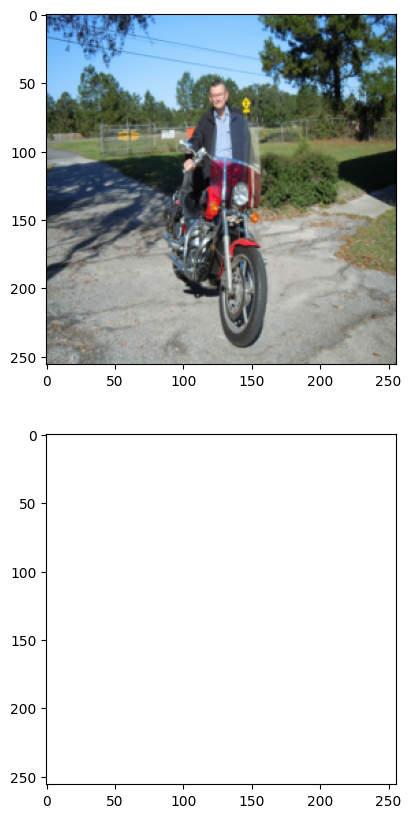

In [35]:
# model = torch.load('background_model.pth').to(device)

img = val_dataset[14][0]
mask = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

show_image(img, mask)

In [ ]:
import os

file_path = "/path/to/file.txt"

if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

In [ ]:
invTrans = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
    std = [ 1/0.5, 1/0.5, 1/0.5 ]),
    transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
    std = [ 1., 1., 1. ]),
  ])

In [ ]:
to_img = transforms.ToPILImage()

<PIL.Image.Image image mode=L size=244x244 at 0x7EFDE86C4E80>
torch.Size([1, 244, 244])


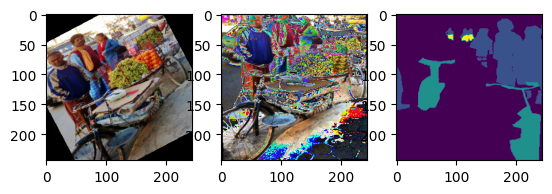

In [ ]:
# show image at index in train_dataset
img_idx = 5

plt.subplot(1, 3, 1)
plt.imshow(to_img(invTrans(train_dataset[img_idx][0])))
plt.subplot(1, 3, 2)
plt.imshow(to_img(train_dataset[img_idx][0]))
plt.subplot(1, 3, 3)
plt.imshow(to_img(train_dataset[img_idx][1]))
print(to_img(train_dataset[img_idx][1]))
print((train_dataset[img_idx][1]).shape)

000000231315


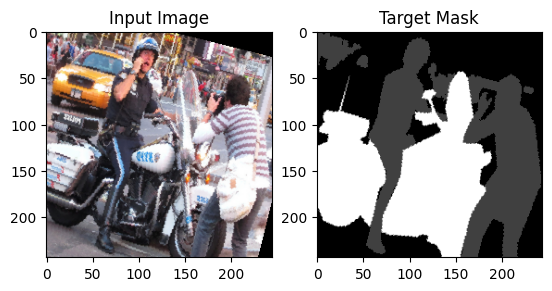

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# images, masks = next(iter(train_loader))
for images, masks, names in train_loader:
  image = images[0]
  mask = masks[0]
  name = names[0]

  print(name)

  # Convert the PyTorch tensors to numpy arrays
  input_img = invTrans(image)
  input_img = input_img.numpy().transpose(1, 2, 0)

  # target_mask = mask.numpy()
  target_mask = to_img(mask)

  # Plot the input image and its corresponding target mask
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(input_img)
  ax[0].set_title('Input Image')
  ax[1].imshow(target_mask, cmap='gray', vmin=0, vmax=4)
  ax[1].set_title('Target Mask')
  plt.show()
  break

# View Images